In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import matplotlib as mpl

from scipy.optimize import curve_fit
from scipy.stats import skewnorm
import scipy.integrate as integrate

In [2]:
Iax_dir = "/Users/tktakaro/Documents/Type-Iax-HST" #"D:/Research/Type-Iax-HST"
mist_dir = Iax_dir + "/MIST/ACS-WFC"

catalog = np.loadtxt(Iax_dir+"/new_files/sn2006my/sn2006my")

In [3]:
pos_predict = np.zeros((catalog.shape[0],2))
info_predict = np.zeros(np.shape(catalog))

j = 0 # Iteration variable for positions array
for i in range(catalog.shape[0]): # Cycles through each object in catalog
    # Checks to make sure point is "good"
    # Good defined by: 1. S/N > 3     2. Sharpness < .3    3. Roundness < 1     4. Crowding < .1 
    if ((catalog[i][5] >= 3.5)&(abs(catalog[i][6]) < .3)&(abs(catalog[i][7]) < 1)
        &(catalog[i][9] < .1)):
        pos_predict[j][0] = catalog[i][2] # Assigns X position
        pos_predict[j][1] = catalog[i][3] # Assigns Y position
        info_predict[j] = catalog[i]
        j = j + 1
                
# Trims all zeros from end of positions array, left from "bad" objects
pos_predict = pos_predict[~np.all(pos_predict == 0, axis=1)]
info_predict = info_predict[~np.all(info_predict == 0, axis=1)]

# Saves high S/N object X,Y positions
np.savetxt("Region_files/sn2006my_Prediction.reg", pos_predict, '%5.2f')

In [4]:
asci = open(Iax_dir + "/jupyter_notebooks/Region_files/sn2006my_200pc.reg", "r+")

def mysplit(s, delim=None):
    return [x for x in s.split(delim) if x]

text = asci.readlines()
region = np.zeros([47,2])
for i in range(47):
    region[i][0] = mysplit(text[i], ' ')[0]
    region[i][1] = mysplit(text[i], ' ')[1]
region = region[~np.all(region == 0, axis=1)]

# Info for each star chosen as real 
info = np.zeros([region.shape[0],info_predict.shape[1]])

j = 0 # Iteration variable for region array
for i in range(info_predict.shape[0]): # Cycles through each star predicted above
    if (region[j][0] == pos_predict[i][0])&(region[j][1] == pos_predict[i][1]):
        info[j] = info_predict[i]
        j = j + 1
        if j == region.shape[0]: break
info = info[~np.all(info == 0, axis=1)]

In [5]:
# Using IRAF to compute actual concentration index, i.e. photometry at .5 pixels to photometry at 3 pixels
ascii_1 = open("/Users/tktakaro/Documents/Type-Iax-HST/new_files/sn2006my/final_ACS_f555w_crc.fits1.mag.1")
ascii_2 = open("/Users/tktakaro/Documents/Type-Iax-HST/new_files/sn2006my/final_ACS_f555w_crc.fits1.mag.2")
text_1 = ascii_1.readlines()
text_2 = ascii_2.readlines()

concentration = np.zeros(47)
for i in range(47):
    if mysplit(text_1[5*i + 79])[4] == 'INDEF': # Removes objects with no defined magnitude at .5 pixels
        concentration[i] = 99
    elif mysplit(text_2[5*i + 79])[4] == 'INDEF': # Removes objects with no defined magnitude at 3 pixels
        concentration[i] = -99
    else: concentration[i] = float(mysplit(text_1[5*i + 79])[4]) - float(mysplit(text_2[5*i + 79])[4])
ascii_1.close()
ascii_2.close()

In [6]:
# Cut out clusters (identified as objects with concentration parameter < 2.3, from Chandar et. al. 2010)
new_info = np.zeros(info.shape)
for i in range(47):
    if (concentration[i] < 2.3): # & (concentration[i] >= 0):
        new_info[i] = info[i]
new_info = new_info[~np.all(new_info == 0, axis=1)]

np.savetxt("jupyter_notebooks/sn2006my_NoClustersROI.reg", new_info[:,2:4], '%5.2f')

In [21]:
info_new = info[:,:]
info = new_info[:,:]

In [8]:
kwargs = {"names": ["EEP", "log10_isochrone_age_yr", "initial_mass", "star_mass", "log_Teff", "log_g",
                    "log_L", "[Fe/H]_init", "[Fe/H]", "ACS_WFC_F435W", "ACS_WFC_F475W", "ACS_WFC_F502N",
                    "ACS_WFC_F550M", "ACS_WFC_F555W", "ACS_WFC_F606W", "ACS_WFC_F625W", "ACS_WFC_F658N",
                    "ACS_WFC_F660N", "ACS_WFC_F775W", "ACS_WFC_F814W", "ACS_WFC_F850LP", "ACS_WFC_F892N", "phase"],
         "delim_whitespace": True, "comment": "#"}
isochrones = {}
for filename in glob.glob(mist_dir + "/*.iso.cmd"):
    filename = filename.replace("\\", "/")
    feh_string = filename.split("/")[-1].split("=")[1].split(".iso")[0] # Pulls metalicity information
    feh = float(feh_string) # feh is [Fe/H]
    df = pandas.read_csv(filename, **kwargs)
    df['ages'] = 10 ** df.log10_isochrone_age_yr / 1e9
    isochrones[feh] = df # Creates dictionary accessible by entering a particular metalicity

In [9]:
# Reddening, metallicity, and distance errors
dist_lower = 30.44 - .24 # Actually distance modulus
dist_upper = 30.44 + .24 # Acutally distance modulus

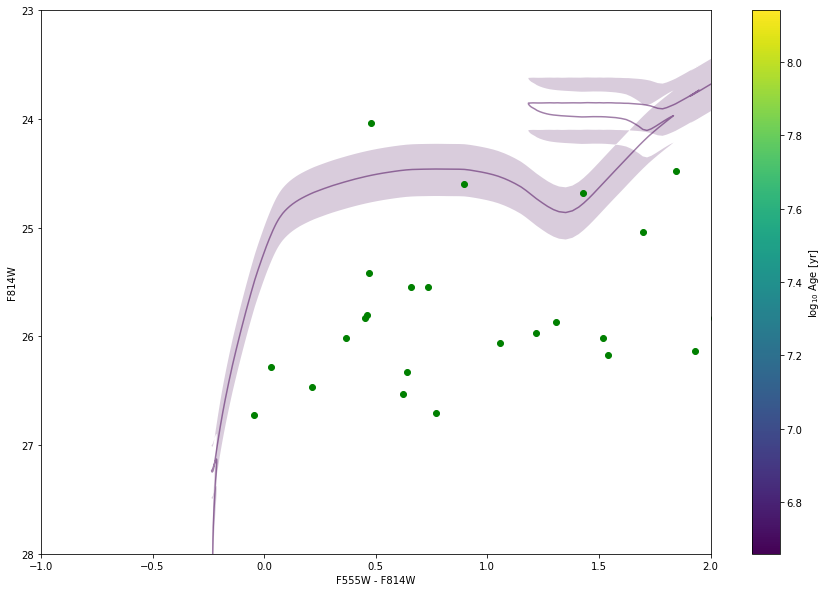

In [10]:
# fix metallicity, vary age
df = isochrones[-0.18]
ages = np.array(list(set(df.log10_isochrone_age_yr)))
ages.sort()

age_cmd = {}

ages = ages[(ages > 7.39) & (ages < 7.41)]
for i, age in enumerate(ages):
    idx = df.log10_isochrone_age_yr == age
    # Three adjustments: 1. Distance: added to mag 2. MW Extinction: added to both. 3. Galactic extinction
    dist_adjust = 5 * (np.log10(12.2e6) - 1)
    F555W_ext = 0.075 # extinction in F555W in NGC 4651 from NED
    F814W_ext = 0.041 # extinction in F555W in NGC 4651 from NED
    Gal_ext = 0
    # Multiply Gal_ext by A_lambda/E(B-V) values from Schlafly, Finkbeiner 2011
    mag = df[idx].ACS_WFC_F814W + dist_adjust + F814W_ext + 1.526*Gal_ext
    mag_lower = df[idx].ACS_WFC_F814W + dist_lower + F814W_ext + 1.526*Gal_ext
    mag_upper = df[idx].ACS_WFC_F814W + dist_upper + F814W_ext + 1.526*Gal_ext
    color = df[idx].ACS_WFC_F555W - df[idx].ACS_WFC_F814W  + F555W_ext - F814W_ext + (2.792 - 1.526) * Gal_ext
    age_cmd[age] = (color, mag, mag_lower, mag_upper)

norm = mpl.colors.Normalize(vmin=ages.min(), vmax=ages.max())
sm = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
sm.set_array(ages)
plt.subplots(figsize=(15, 10))
for age, (color, mag, mag_lower, mag_upper) in age_cmd.items():
    plt.plot(color, mag, alpha=0.5, color=sm.to_rgba(age), zorder=0)
    plt.fill_between(color, mag_lower, mag_upper, facecolor=sm.to_rgba(age), alpha=0.2, edgecolor='none')
    
# Plots stars
plt.plot(new_info[:,15] - new_info[:,28], new_info[:,28], 'go')

plt.xlabel("F555W - F814W")
plt.ylabel("F814W")
plt.ylim(28,23)
plt.xlim(-1, 2)
cb = plt.colorbar(sm)
cb.set_label('$\log_{10}$ Age [yr]')
plt.draw()
plt.show()

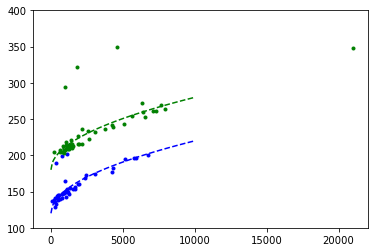

In [11]:
# Testing to find relationship between flux and flux error
x_array=np.linspace(0, 10000, num=100)

plt.plot(info[:,11], info[:,17]/1.0857 * info[:,11], 'b.')
plt.plot(x_array, 120 + np.sqrt(x_array), 'b--')
plt.plot(info[:,24], info[:,30]/1.0857 * info[:,24], 'g.')
plt.plot(x_array, 180 + np.sqrt(x_array), 'g--')
plt.ylim(100,400)
plt.show()

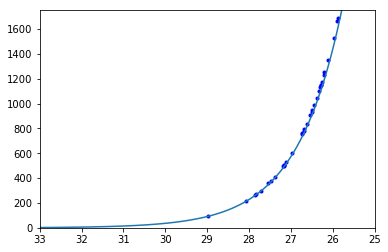

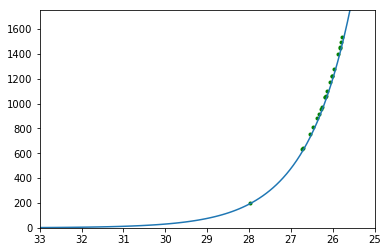

In [12]:
x_array = np.linspace(25,33,100)
plt.ylim(0,1750)
plt.xlim(33,25)
plt.plot(info[:,15], info[:,11], 'b.')
plt.plot(x_array, 1.7*1090 * 10**((25.722 - x_array)/2.5))
plt.show()

plt.ylim(0,1750)
plt.xlim(33,25)
plt.plot(info[:,28], info[:,24], 'g.')
plt.plot(x_array, 1.7*1090 * 10**((25.525 - x_array)/2.5))
plt.show()

In [22]:
metallicity = np.array([-.40, -.29, -.18, -.07, .04])
reddening = np.array([0])
SN_pos = np.array([4850.23, 2332.4071])
CChi = np.zeros([metallicity.size, reddening.size, 41, 4, 1]) #41 = n_ages
CChi_temp = np.zeros([2,1])

for k, met in enumerate(metallicity):
    df = isochrones[met] # Sets metallicity.
    ages = np.array(list(set(df.log10_isochrone_age_yr)))
    ages = ages[(ages > 6.49) & (ages < 8.51)]
    ages.sort()
    for j, red in enumerate(reddening):
        for i, age in enumerate(ages):
            CChi[k, j, i, 1, :] = met
            CChi[k, j, i, 2, :] = red
            CChi[k, j, i, 3, :] = age
            
            idx = df.log10_isochrone_age_yr == age
            mag_555 = df[idx].ACS_WFC_F555W + dist_adjust + F555W_ext + 2.792*red
            mag_814 = df[idx].ACS_WFC_F814W + dist_adjust + F814W_ext + 1.526*red
            
            
            phys_dist_temp = 0 # This will hold the total physical distance weights to be averaged and divided out to normalize
            temp = 0 # This will hold the distance for each data point to the line
    
            # Sets the radial dispersion for the region
            sigma = 5 * (.92 * 10**age * 3.15e7 * 206265)/(12.2e6 * 3.086e13 * .05) # Replace 10**age w/ 10000000
            flat = (100 * 206265)/(12.2e6 * .05) # 100 parsecs in pixels
            flat_int = int(np.round(flat*5))
            for l in range(info.shape[0]):
                # Removes "stars" with mag > 90 in any band
                if (info[l,15] > 90) or (info[l,28] > 90):
                    continue
        
                # Uses physical distance between star and SN position to weight each star
                phys_dist = np.sqrt((SN_pos[0] - info[l,2])**2 + (SN_pos[1] - info[l,3])**2)
                weight_func = np.convolve(1/(np.sqrt(2 * np.pi) * sigma) * np.exp(- np.linspace(-200,200,2000)**2/(2 * sigma**2)),
                   np.append(np.zeros(int(np.ceil((2000-flat_int)/2))),np.append(np.ones(flat_int),np.zeros(int(np.floor((2000-flat_int)/2))))))
                phys_dist_weight = weight_func[1999 + int(phys_dist*5)]
                phys_dist_temp += phys_dist_weight # Will be used to compute average of the weights
        
                # Adds the difference in mags for each data point in quadrature.
                temp += (phys_dist_weight * np.amin(np.sqrt((info[l,15] - mag_555)**2
                  + (info[l,28] - mag_814)**2)))**2
    
            # There are six stars not counted, as they have >90 mag in some filter
            phys_dist_temp /= (info.shape[0] - 3)
            CChi[k,j,i,0,:] = np.sqrt(temp)/phys_dist_temp

In [20]:
# Now, replace the fitting functions (previously polynomials) with skew normal distributions
from scipy.optimize import curve_fit
from scipy.stats import skewnorm

# This is the function which will be fed to the fitting algorithm.
def skew(x, norm, a, loc, scale):
    return norm * skewnorm.pdf(x, a, loc=loc, scale=scale)

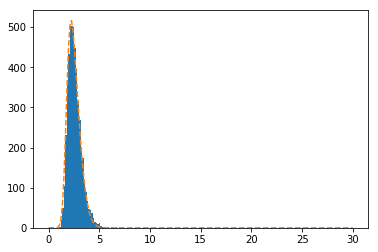

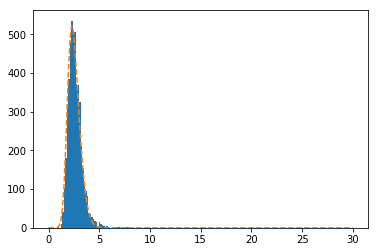

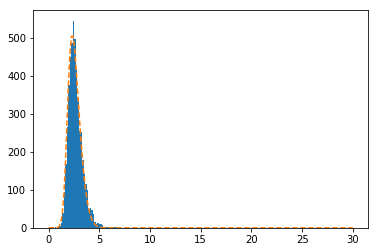

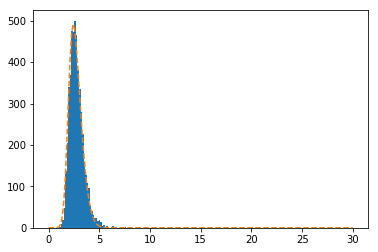

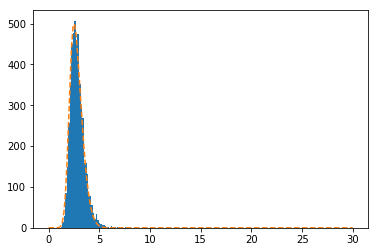

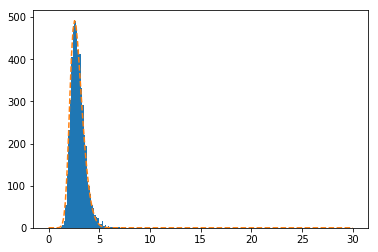

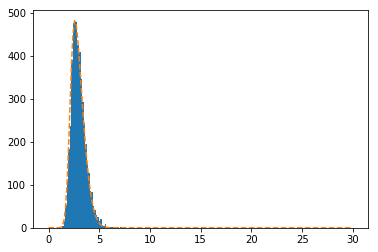

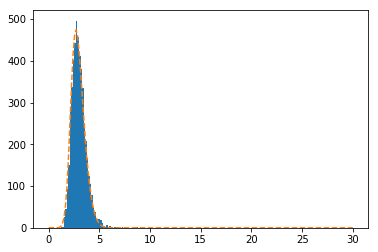

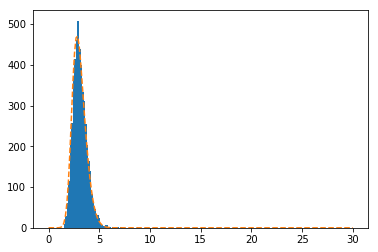

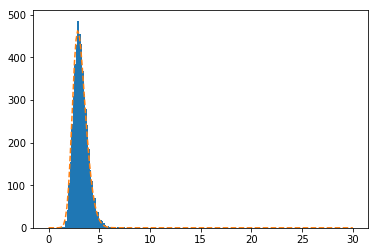

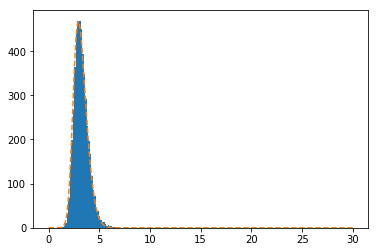

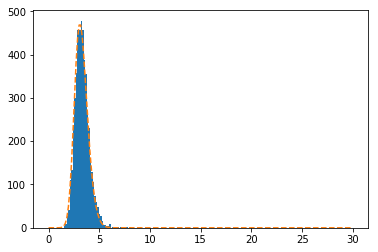

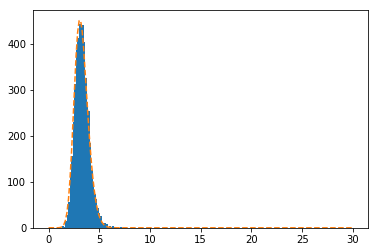

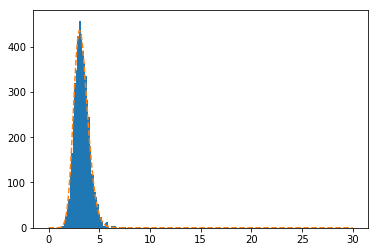

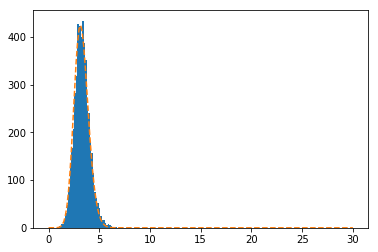

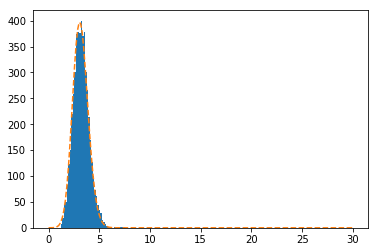

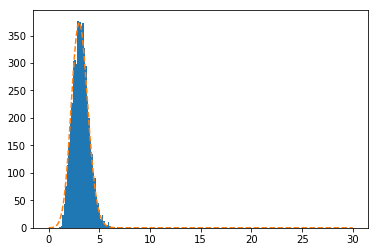

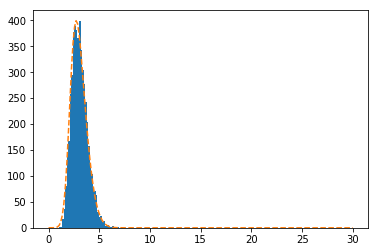

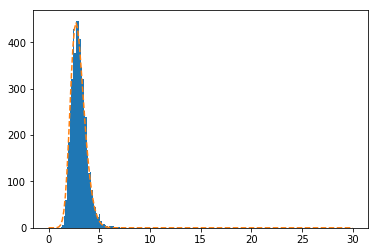

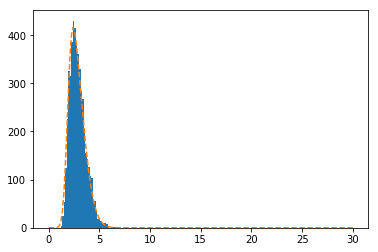

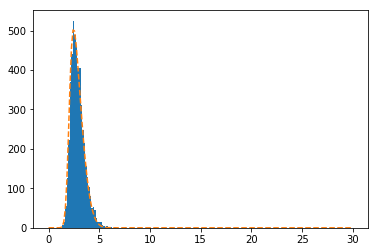

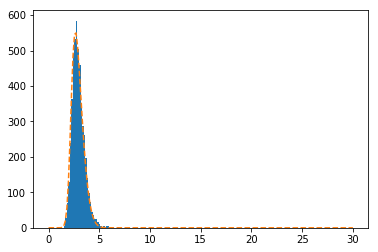

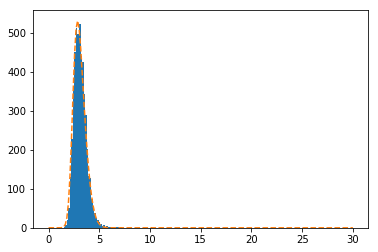

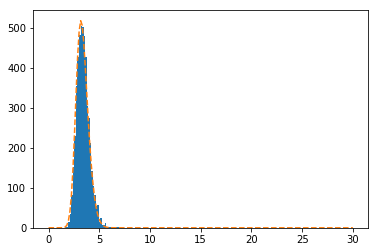

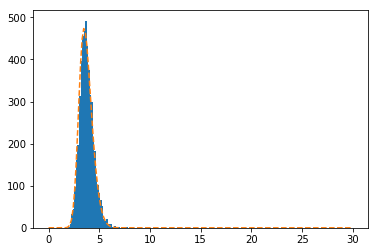

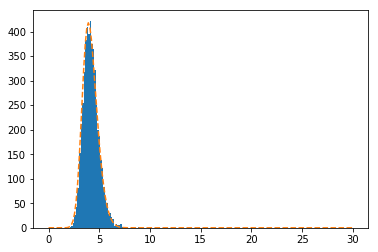

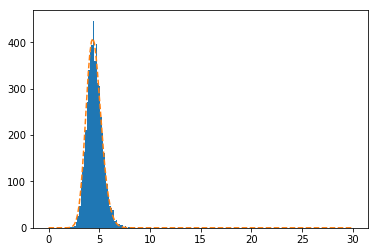

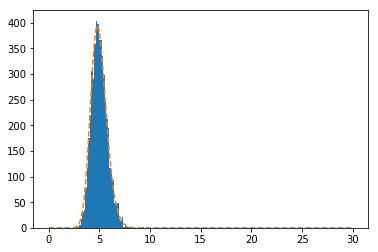

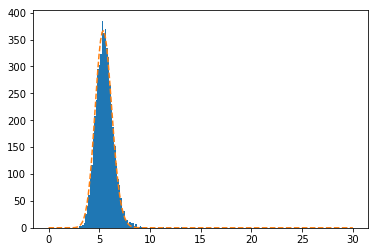

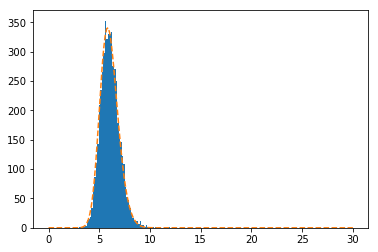

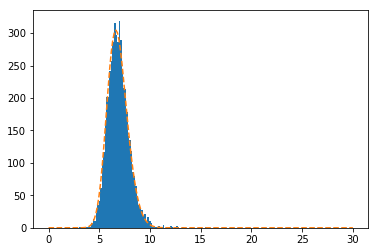

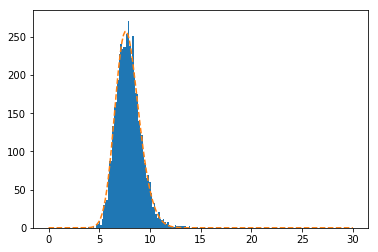

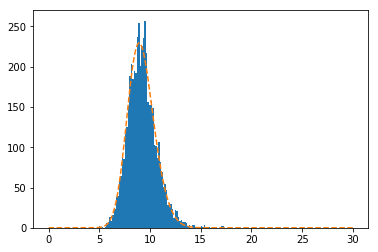

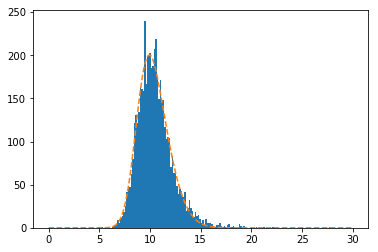

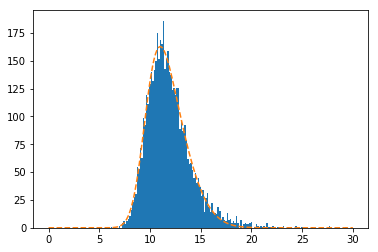

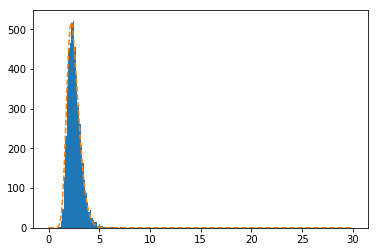

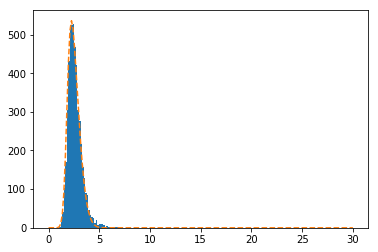

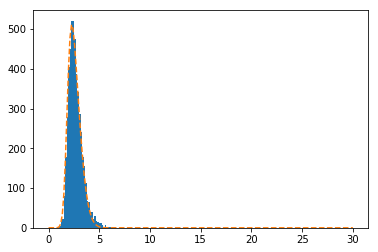

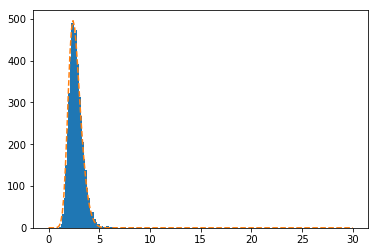

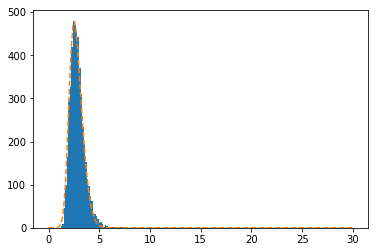

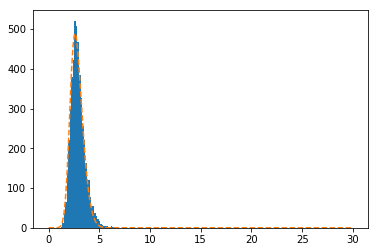

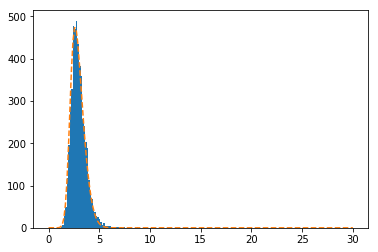

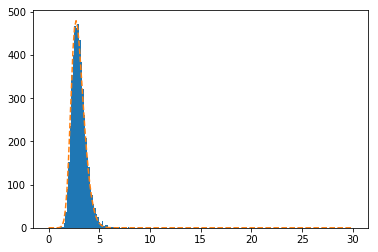

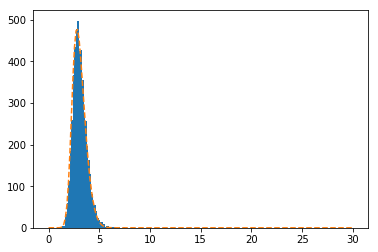

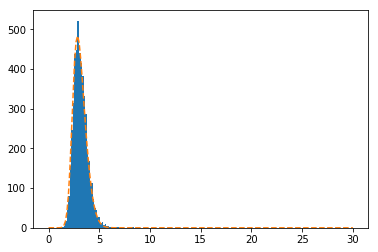

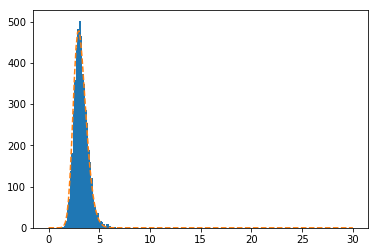

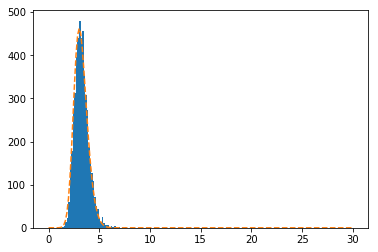

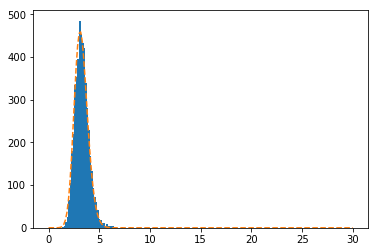

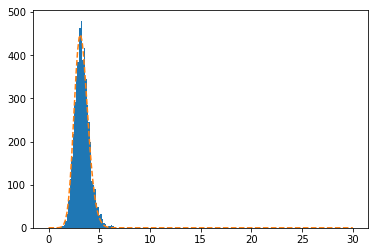

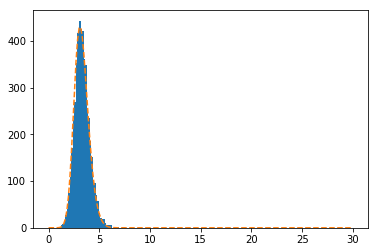

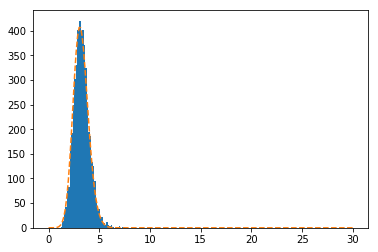

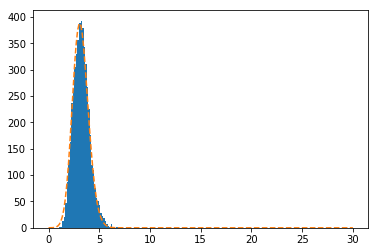

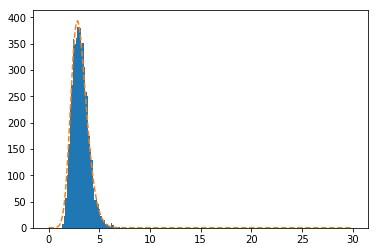

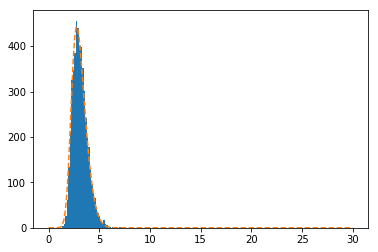

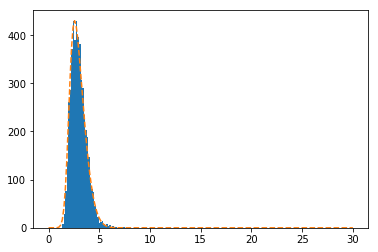

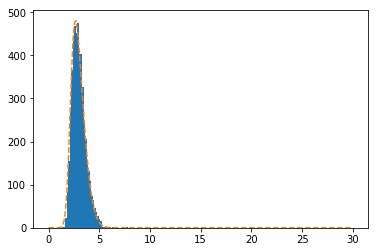

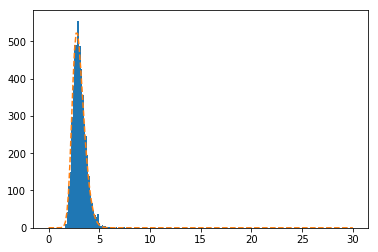

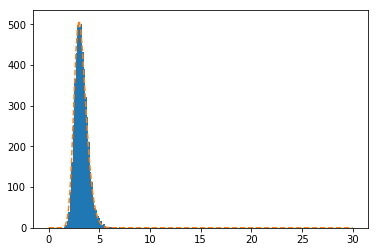

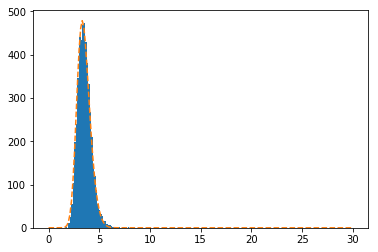

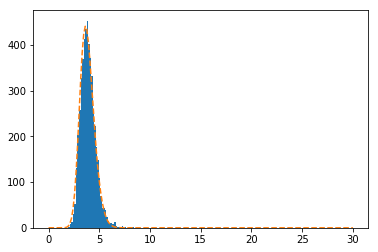

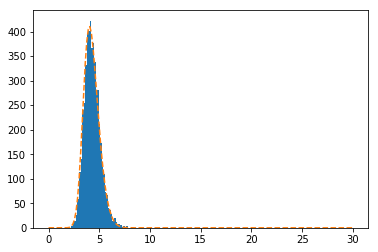

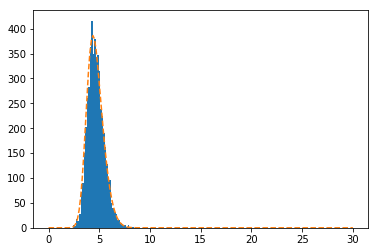

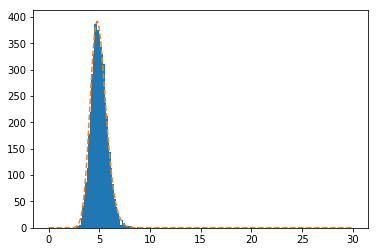

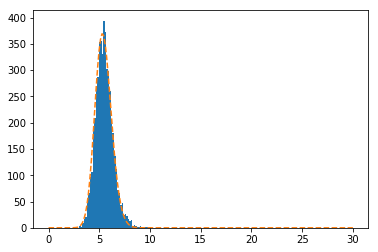

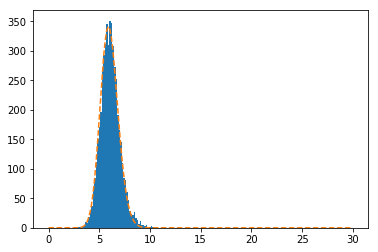

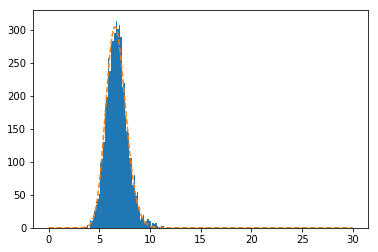

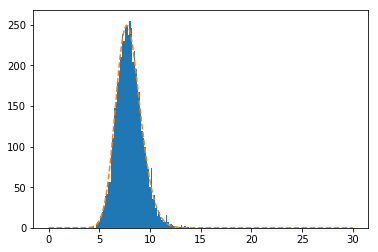

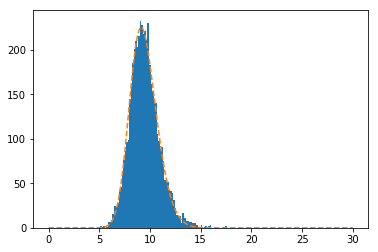

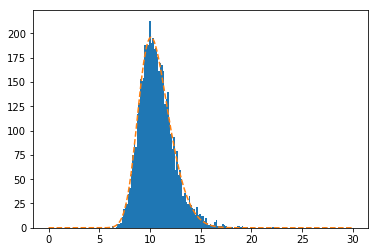

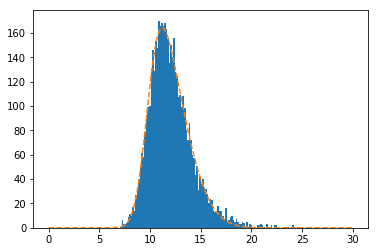

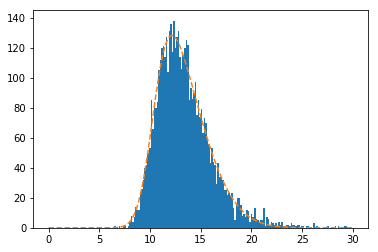

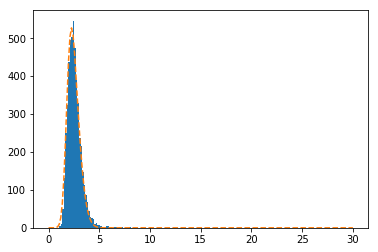

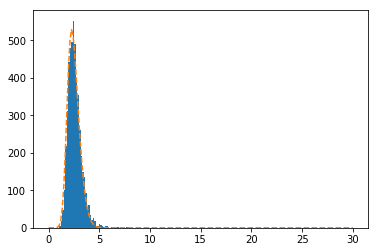

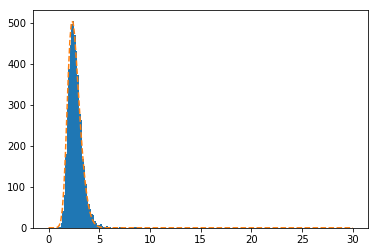

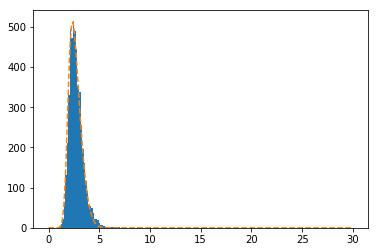

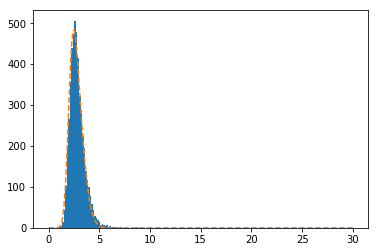

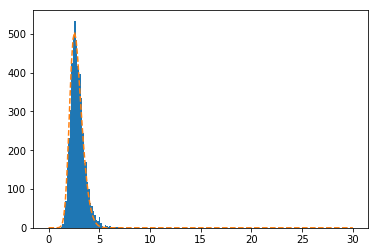

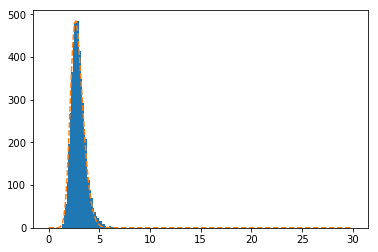

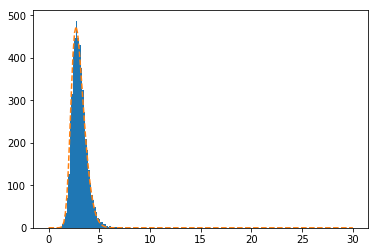

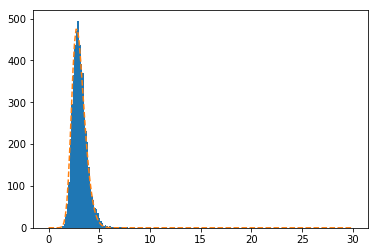

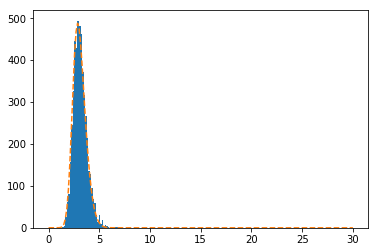

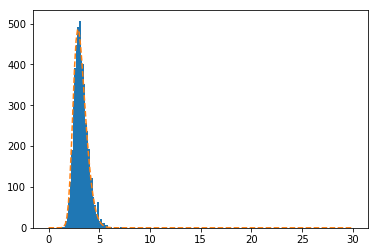

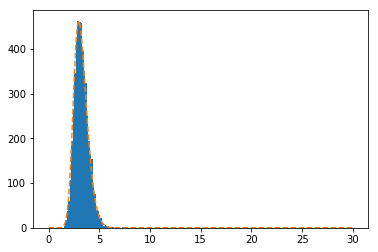

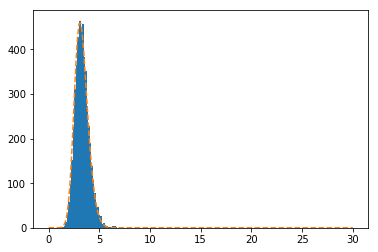

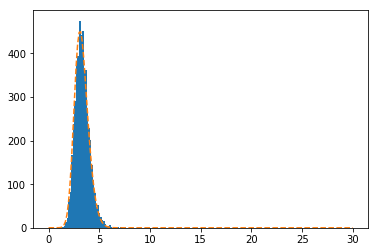

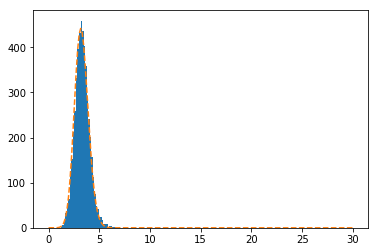

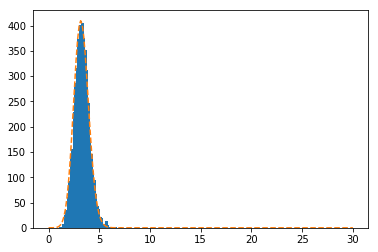

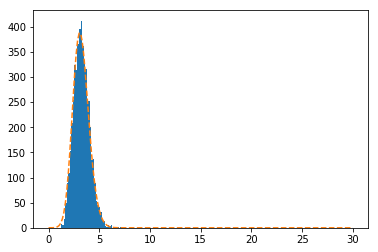

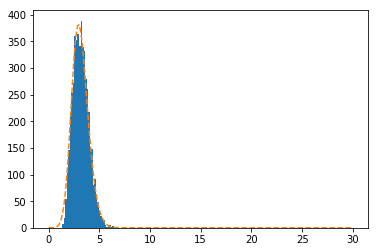

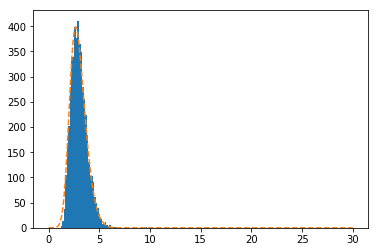

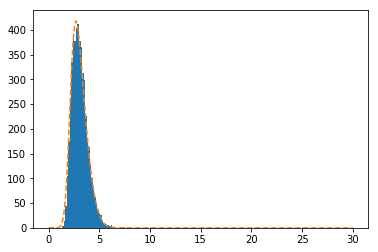

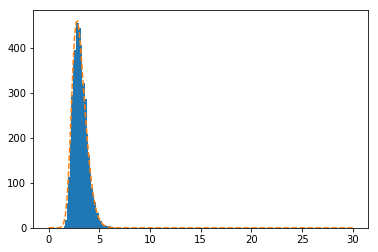

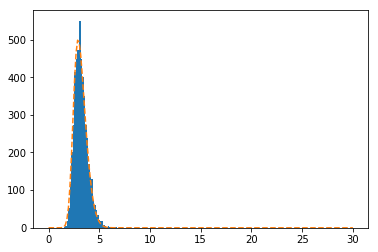

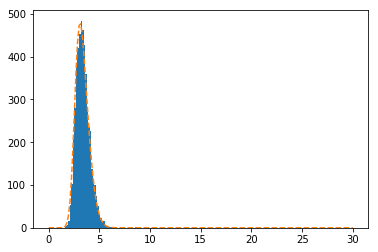

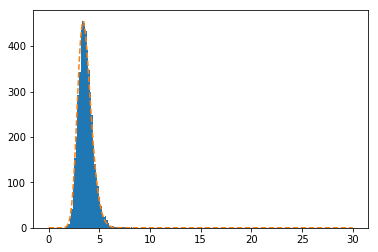

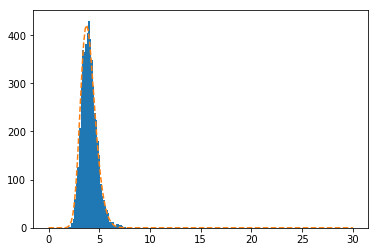

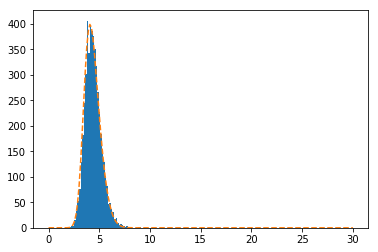

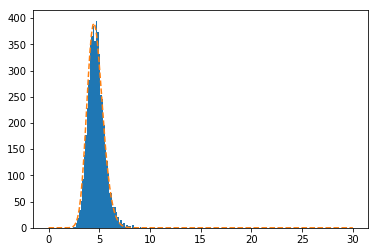

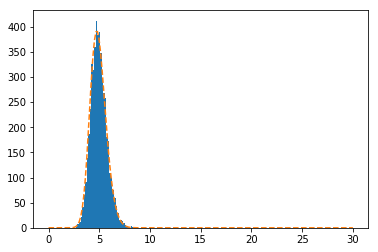

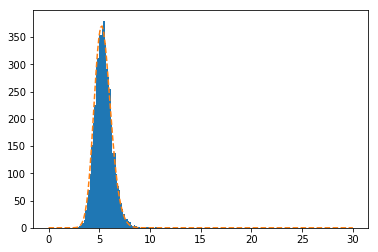

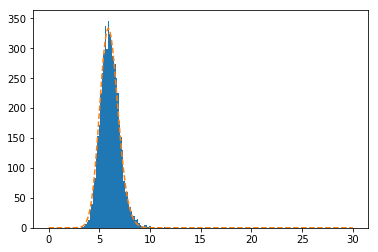

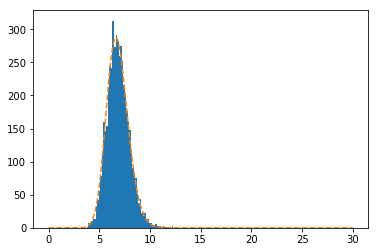

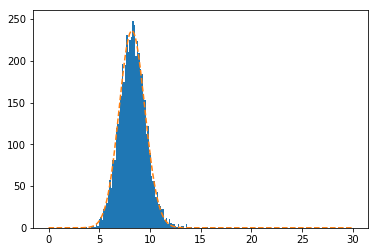

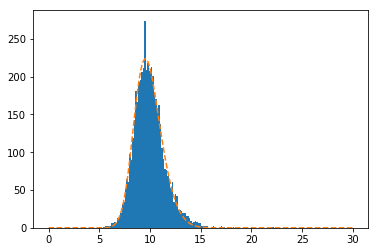

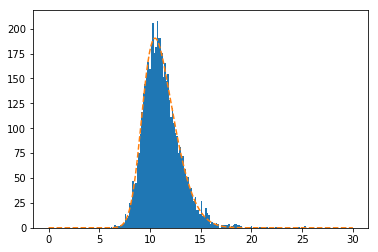

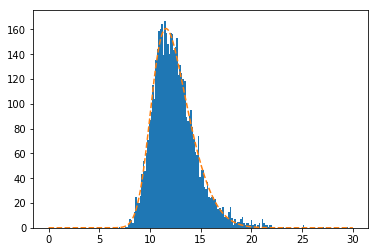

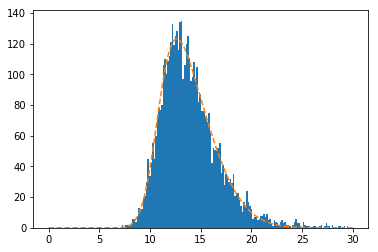

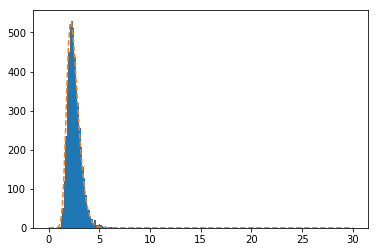

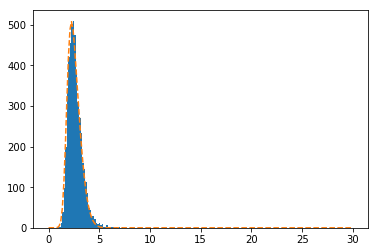

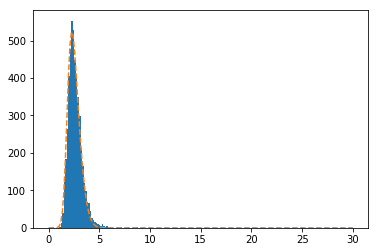

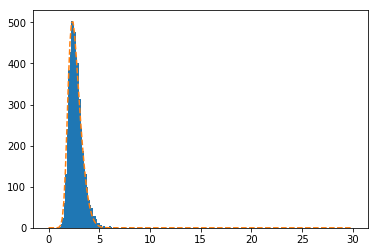

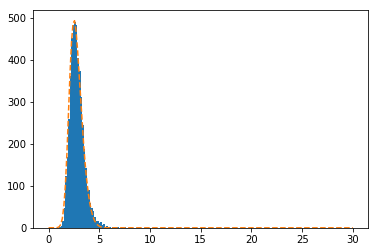

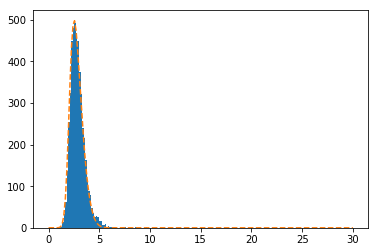

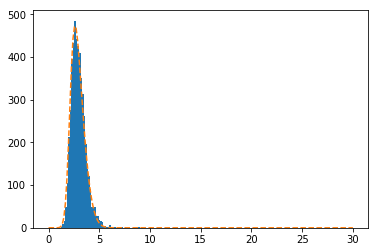

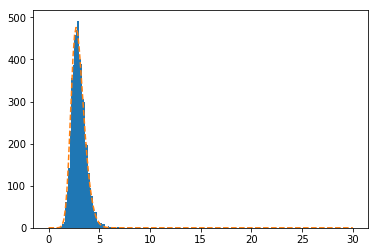

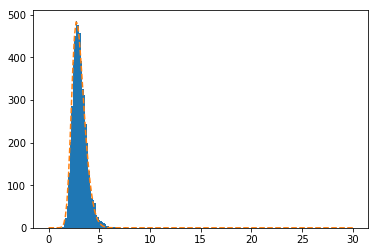

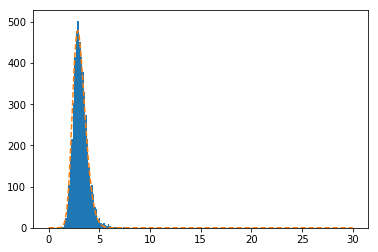

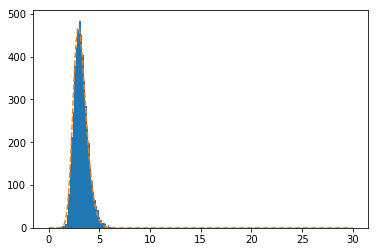

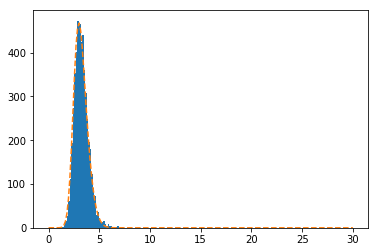

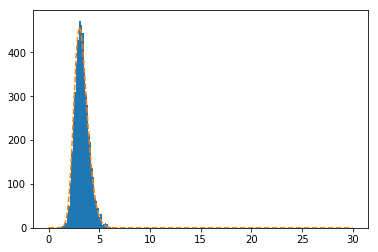

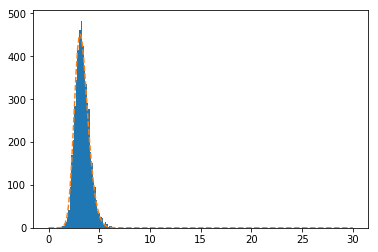

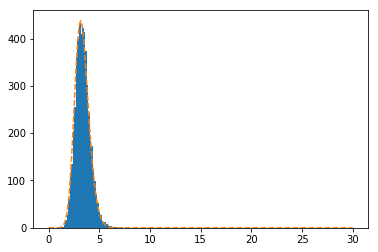

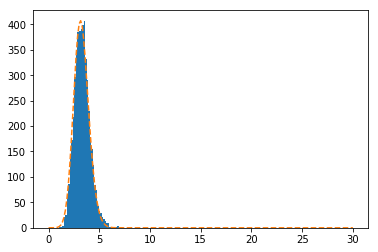

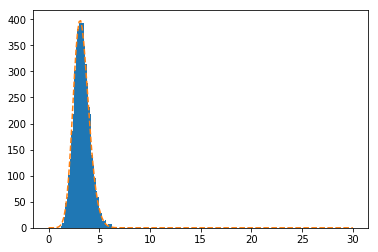

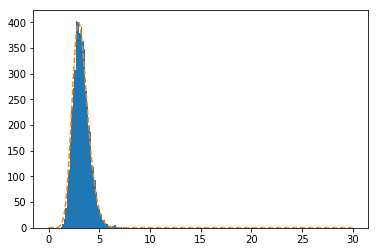

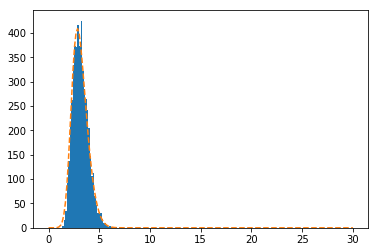

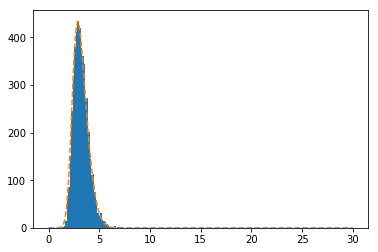

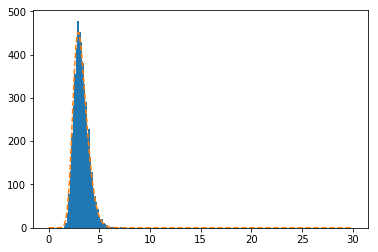

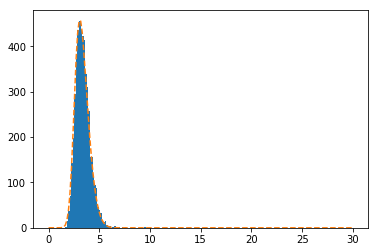

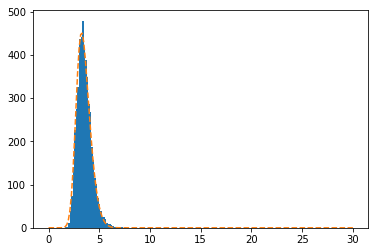

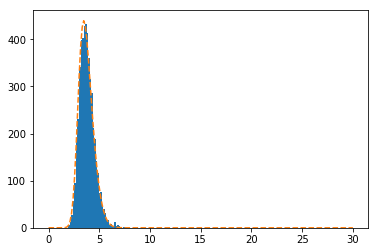

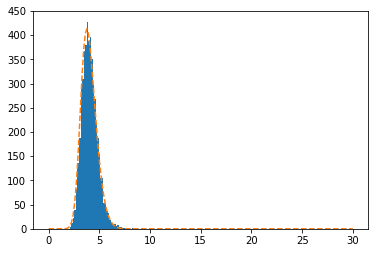

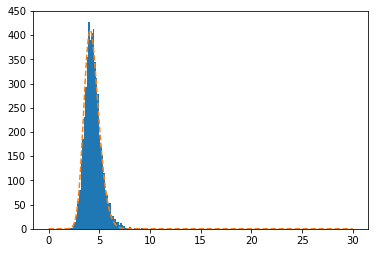

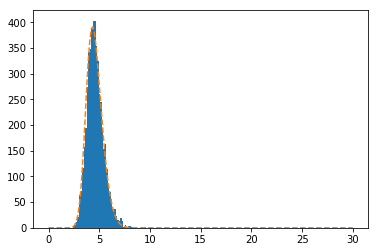

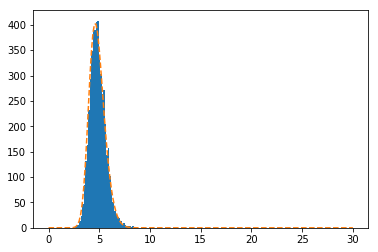

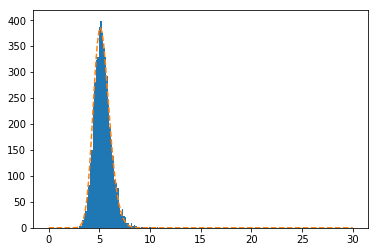

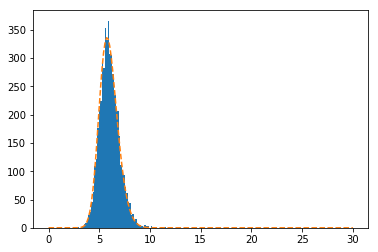

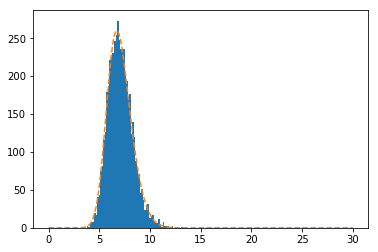

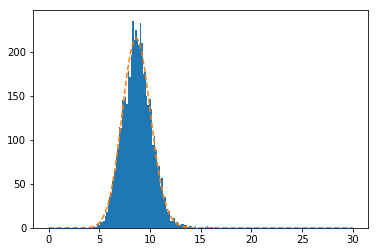

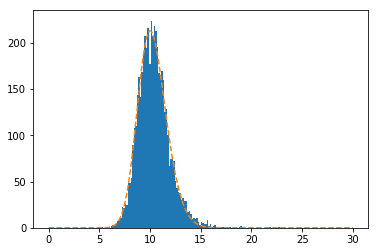

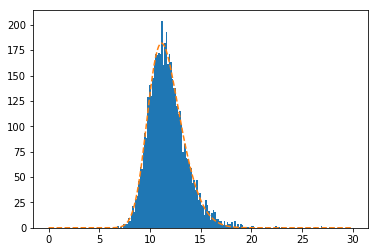

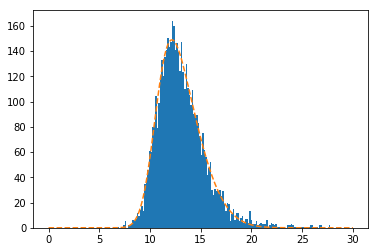

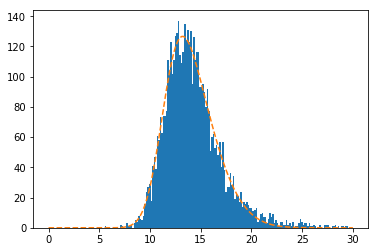

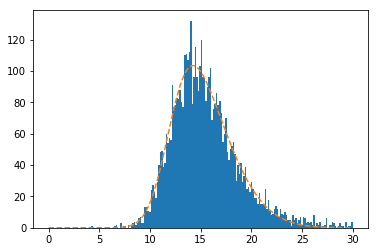

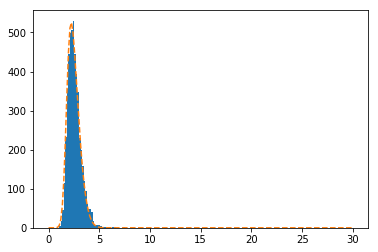

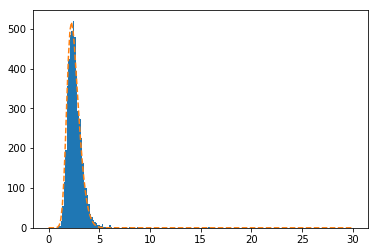

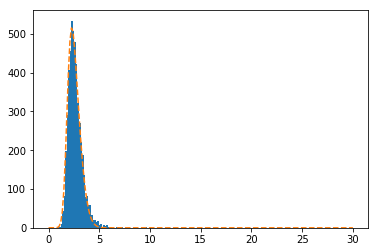

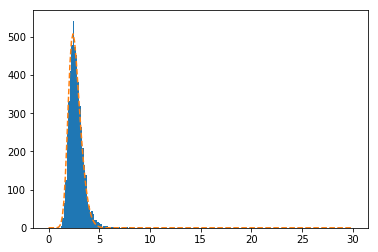

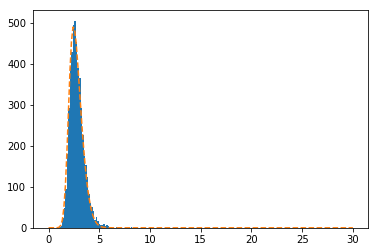

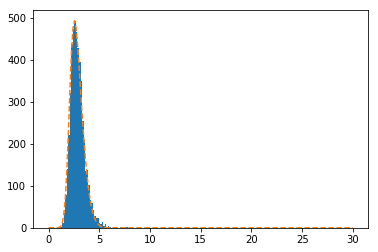

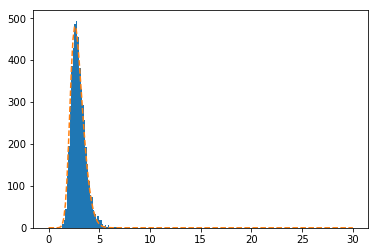

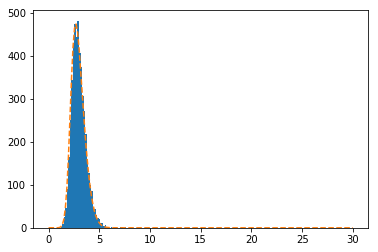

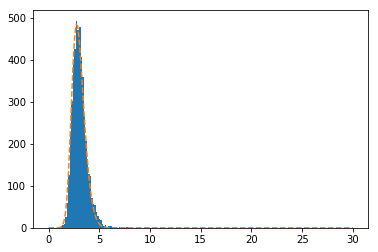

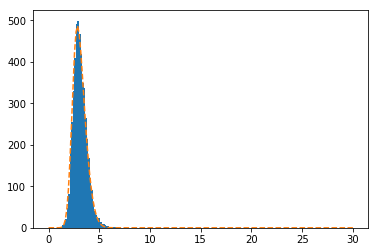

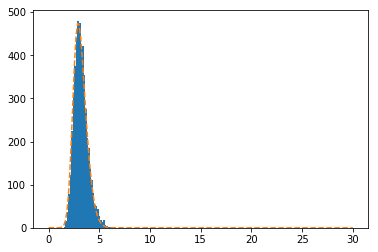

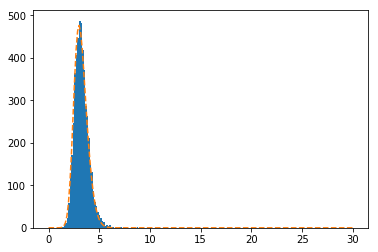

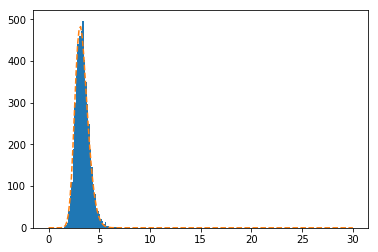

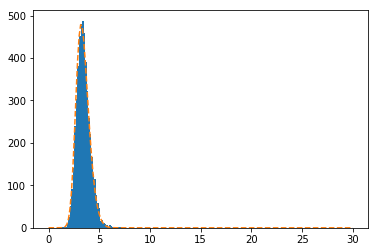

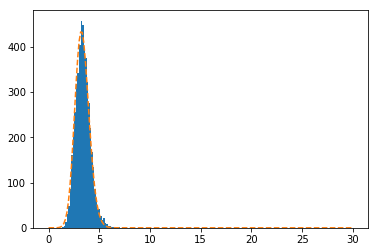

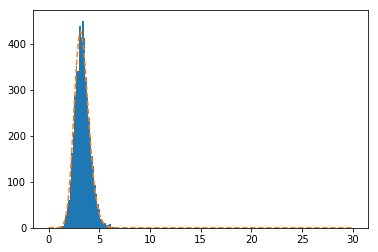

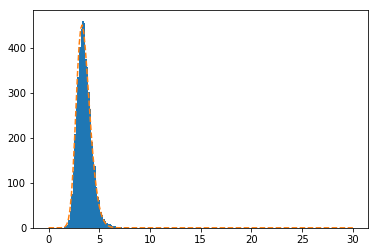

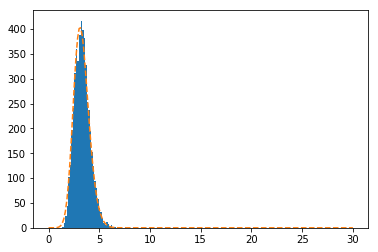

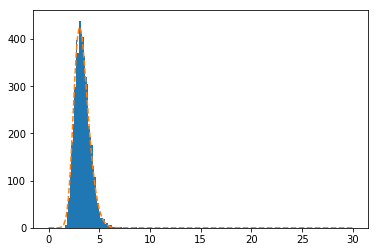

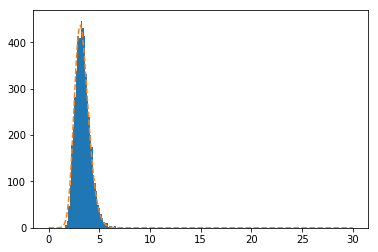

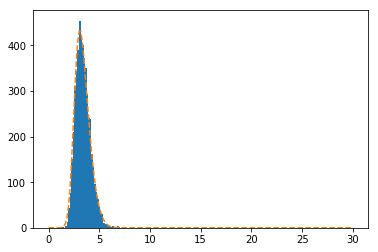

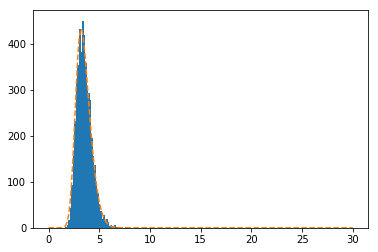

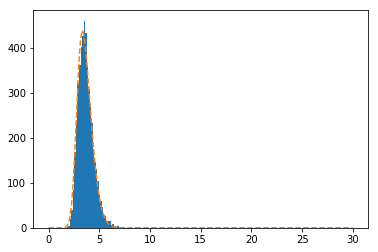

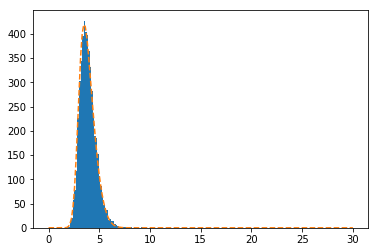

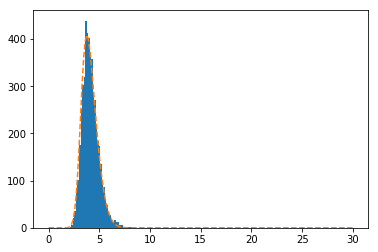

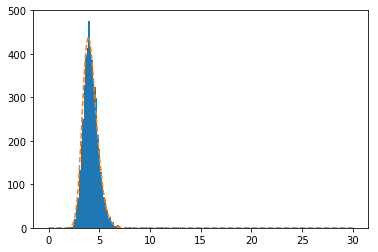

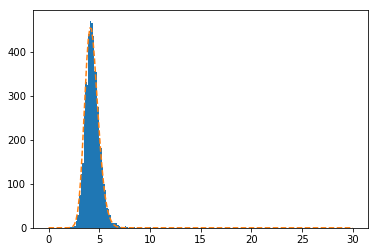

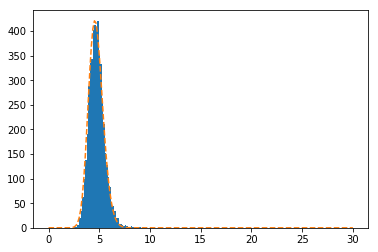

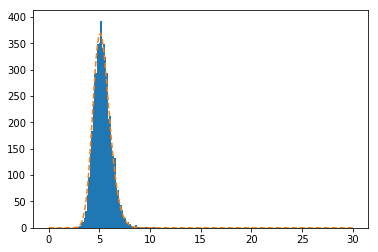

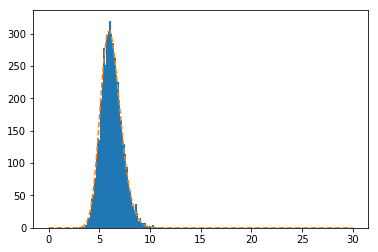

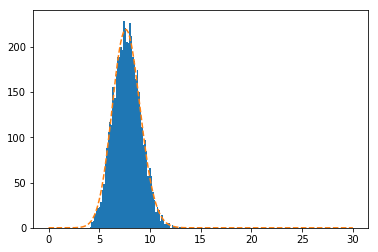

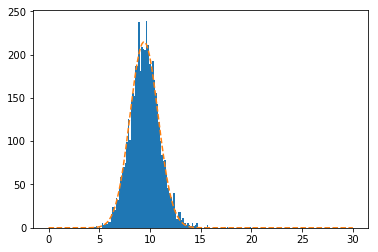

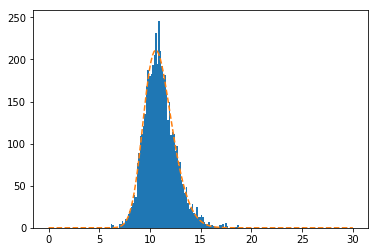

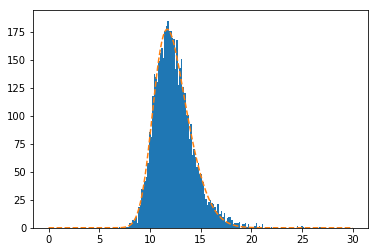

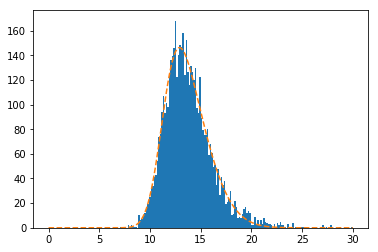

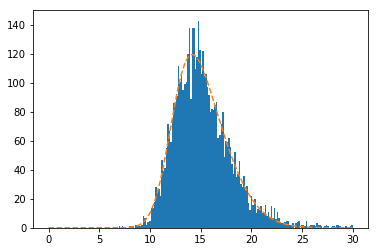

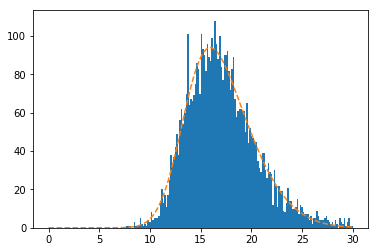

In [28]:
x = np.linspace(0,30,200)
probs = np.zeros([metallicity.size, reddening.size, 41]) #[]

CChi_false = np.load("MC_06my_Complete/CChi_false_ages.npy")#"MC_08ha_Curtis_Dolphot3/CChi_false_ages.npy")
for k, met in enumerate(metallicity):
    df = isochrones[met]
    ages = np.array(list(set(df.log10_isochrone_age_yr)))
    ages = ages[(ages > 6.49) & (ages < 8.51)]
    ages.sort()
    for j, red in enumerate(reddening):
        popt = (2000,3,2,2)
        for i, age in enumerate(ages):
            halt = False
            for l in range(5000):
                if np.isinf(CChi_false[k,j,i,0,l]) or np.isnan(CChi_false[k,j,i,0,l]):
                    CChi_false[k,j,i,0,l] = 999999999999
                    halt = True
                    probs[k,j,i] = 0
                    break
            if halt == True:
                probs[k,j,i] = 0
                continue
            y = plt.hist(30./16 * CChi_false[k,j,i,0,:], bins=np.linspace(0,30,201))[0]
            try:
                popt, pcov = curve_fit(skew, x, y, p0=(2000,3,2,2))
            except RuntimeError:
                print(met, red, age)
                popt = [.1 * p for p in popt]
                popt, pcov = curve_fit(skew, x, y, p0=popt)
            plt.plot(x, skew(x, *popt), '--')
            plt.show()
            norm = integrate.quad(skew, 0, 30, args=(popt[0], popt[1], popt[2], popt[3]))[0]
            probs[k,j,i] = skew(CChi[k,j,i,0,0], *popt)/norm

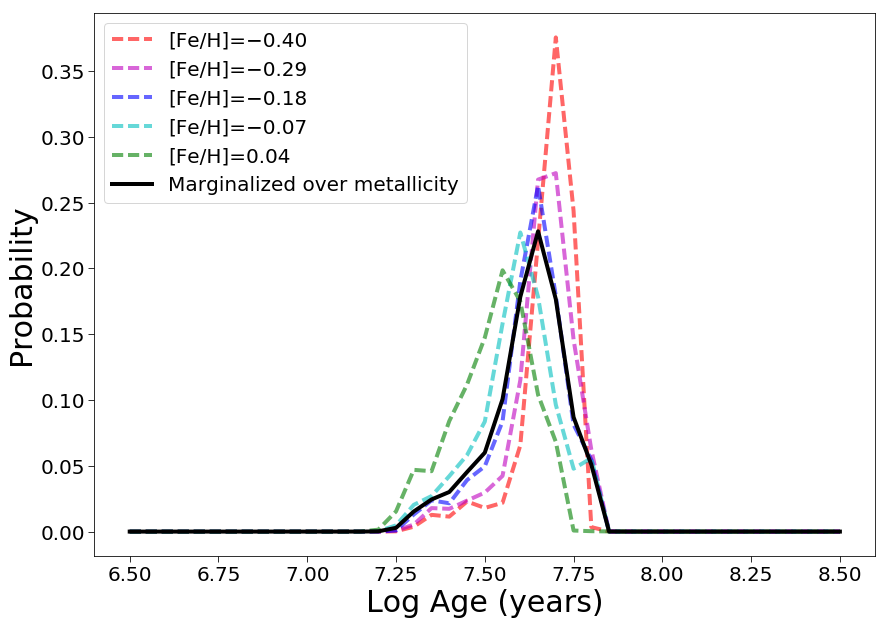

7.65


In [30]:
# Plotting all metallicities, assuming no reddening
fig, ax = plt.subplots(figsize=(14, 10));
plt.plot(CChi[0, 0, :, 3, 0], probs[0,0,:]/np.sum(probs[0,0,:]), 'r--', linewidth=4, alpha=.6, label='[Fe/H]=−0.40')
plt.plot(CChi[1, 0, :, 3, 0], probs[1,0,:]/np.sum(probs[1,0,:]), 'm--', linewidth=4, alpha=.6, label='[Fe/H]=−0.29')
plt.plot(CChi[2, 0, :, 3, 0], probs[2,0,:]/np.sum(probs[2,0,:]), 'b--', linewidth=4, alpha=.6, label='[Fe/H]=−0.18')
plt.plot(CChi[3, 0, :, 3, 0], probs[3,0,:]/np.sum(probs[3,0,:]), 'c--', linewidth=4, alpha=.6, label='[Fe/H]=−0.07')
plt.plot(CChi[4, 0, :, 3, 0], probs[4,0,:]/np.sum(probs[4,0,:]), 'g--', linewidth=4, alpha=.6, label='[Fe/H]=0.04')

# Applying a gaussian prior
mu = -0.18
sigma = .11
def norm(x):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

probs_tot = (probs[0,0,:] * norm(-.40) + probs[1,0,:] * norm(-.29) + probs[2,0,:] * norm(-.18) + 
            probs[3,0,:] * norm(-.07) + probs[4,0,:] * norm(.04))/(
            norm(-.40) + norm(-.29) + norm(-.18) + norm(-.07) + norm(.04))
plt.plot(CChi[0,0,:,3,0], probs_tot/np.sum(probs_tot), 'k', linewidth=4, label='Marginalized over metallicity')

plt.ylabel("Probability", size=30)
plt.xlabel("Log Age (years)", size=30)
ax.tick_params(axis='both', which='major', labelsize=20, length=6)
ax.tick_params(axis='both', which='minor', length=4)
plt.legend(fontsize=20)
plt.savefig('2006my_metallicity', dpi=1000)
plt.show()


print(CChi[0,0,:,3,0][np.argmax(probs_tot)])
np.save("Region_files/06my_Mag_probs", probs_tot)

In [31]:
# Direct imaging finds M_min = 7 M_sol, M_med = 10 M_sol, M_max = 15 M_sol,
# corresponding to Age_min = 14.4 Myr, Age_med = 26.9 Myr, Age_max = 54.6 Myr
print("We find Age_med = ", 10**(CChi[0,0,:,3,0][np.argmax(probs_tot)])/1e6,
     "Myr, Age_min = ", 10**(7.25)/1e6, 
     "Myr, Age_max = ", 10**(7.8)/1e6, "Myr")

We find Age_med =  44.6683592151 Myr, Age_min =  17.78279410038923 Myr, Age_max =  63.09573444801929 Myr


## False Star Fitting

In [25]:
# Generate false stars
x_pos = 4782 + 136*np.random.rand(50)
y_pos = 2264 + 136*np.random.rand(50)

f435w_mags = 18 + 12*np.random.rand(1000) # Range of 18 to 30 in mag
Iax_dir = "/Users/tktakaro/Documents/Type-Iax-HST"
file = open(Iax_dir + "/new_files/sn2006my/fake_stars.list", "w+")
for j in range(x_pos.size):
    for i in range(f435w_mags.size):
        file.write('0 1 {x} {y} {f4} {f4} {f4} {f4}\n'.format(x=x_pos[j], y=y_pos[j], f4=f435w_mags[i]))
file.close()

In [26]:
# Loading in the false star test
catalog_false_f555w = np.loadtxt(Iax_dir + "/new_files/sn2006my/sn2006my_f555w.fake")
catalog_false_f814w = np.loadtxt(Iax_dir + "/new_files/sn2006my/sn2006my_f814w.fake")

In [28]:
recovered_mags = np.zeros([50000,13]) # 1. X position, 2. Y position, 3. Inserted Mag, 4. Recovered mag (f435w),
# 5. S/N (f435w), 6. Sharpness (f435w), 7. Roundness (f435w), 8. Crowding (f435w), 9.+ same, for other filters
for i in range(catalog_false_f555w.shape[0]):
    # X, Y, and Inserted Magnitude
    recovered_mags[i,0] = catalog_false_f555w[i,2]
    recovered_mags[i,1] = catalog_false_f555w[i,3]
    recovered_mags[i,2] = catalog_false_f555w[i,5]
    # Recovered mag in F435W
    if (catalog_false_f555w[i,14] == 0) and (catalog_false_f555w[i,15] == 0):
        recovered_mags[i,3] = 99.999
    else:
        recovered_mags[i,3] = catalog_false_f555w[i,27]
        recovered_mags[i,4:8] = catalog_false_f555w[i,17:21]
    # Recovered mag in F555W
    if (catalog_false_f814w[i,14] == 0) and (catalog_false_f814w[i,15] == 0):
        recovered_mags[i,8] = 99.999
    else:
        recovered_mags[i,8] = catalog_false_f814w[i,27]
        recovered_mags[i,9:13] = catalog_false_f814w[i,17:21]

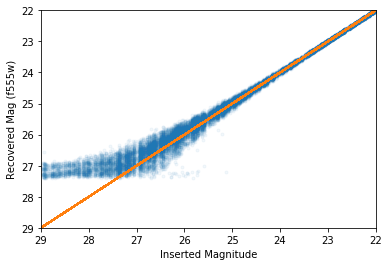

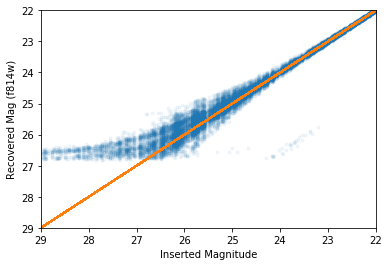

In [29]:
plt.plot(recovered_mags[:,2], recovered_mags[:,3], '.', alpha=.05)
plt.plot(recovered_mags[:,2], recovered_mags[:,2], '--')
plt.ylim(29,22)
plt.xlim(29,22)
plt.xlabel("Inserted Magnitude")
plt.ylabel("Recovered Mag (f555w)")
plt.show()

plt.plot(recovered_mags[:,2], recovered_mags[:,8], '.', alpha=.05)
plt.plot(recovered_mags[:,2], recovered_mags[:,2], '--')
plt.ylim(29,22)
plt.xlim(29,22)
plt.xlabel("Inserted Magnitude")
plt.ylabel("Recovered Mag (f814w)")
plt.show()

In [31]:
f555w_mags = []
f555w_recover = []
f814w_mags = []
f814w_recover = []
# Calculate recovery percentage as a function of inserted mag
for i in range(catalog_false_f555w.shape[0]):
    f555w_mags.append(recovered_mags[i,2])
    f814w_mags.append(recovered_mags[i,2])
    if abs(recovered_mags[i,2] - recovered_mags[i,3]) < .5:
        f555w_recover.append(recovered_mags[i,2])
    if abs(recovered_mags[i,2] - recovered_mags[i,8]) < .5:
        f814w_recover.append(recovered_mags[i,2])

In [32]:
# Setting up the histogram bins w/ .1 mag resolution
b = []
for i in range(121):
    b.append(17 + i/10.)

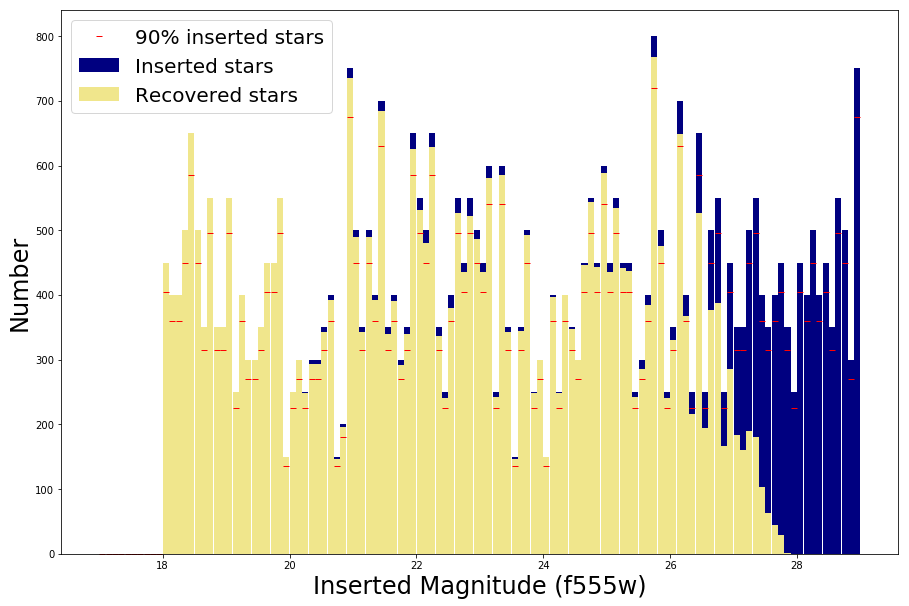

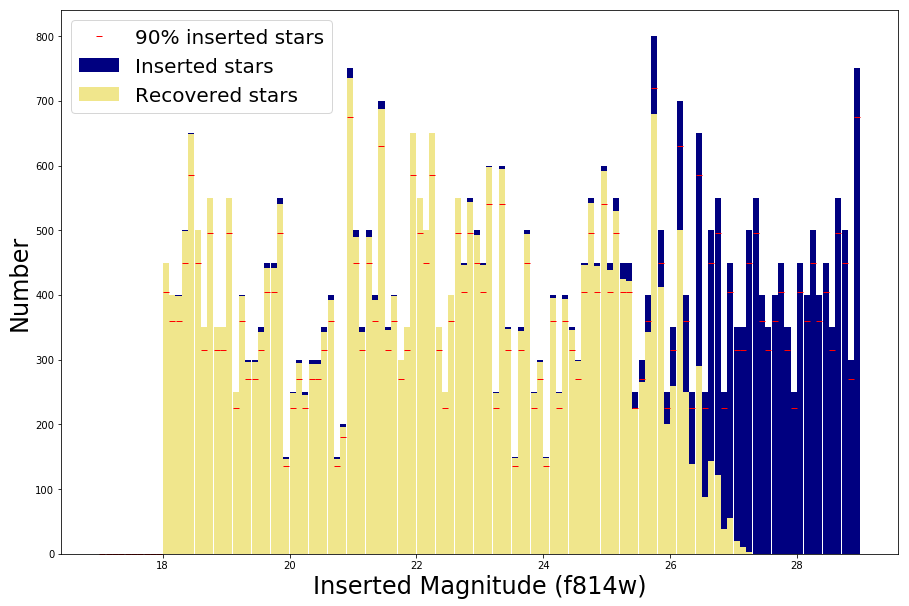

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


In [33]:
#b = [17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25,25.5,26,26.5,27,27.5,28,28.5,29,29.5,30]
plt.subplots(figsize=(15, 10))
h5 = plt.hist(f555w_mags, bins=b, facecolor='navy', rwidth=.95, label='Inserted stars')
r5 = plt.hist(f555w_recover, bins=b, rwidth=.95, facecolor='khaki', label='Recovered stars')
plt.plot(h5[1][:-1]+.05, .9*h5[0], 'r_', markersize=6, label='90% inserted stars')
plt.xlabel("Inserted Magnitude (f555w)", fontsize=24)
plt.ylabel("Number", fontsize=24)
plt.legend(fontsize=20)
plt.show()


plt.subplots(figsize=(15, 10))
h8 = plt.hist(f814w_mags, bins=b, facecolor='navy', rwidth=.95, label='Inserted stars')
r8 = plt.hist(f814w_recover, bins=b, rwidth=.95, facecolor='khaki', label='Recovered stars')
plt.plot(h8[1][:-1]+.05, .9*h8[0], 'r_', markersize=6, label='90% inserted stars')
plt.xlabel("Inserted Magnitude (f814w)", fontsize=24)
plt.ylabel("Number", fontsize=24)
plt.legend(fontsize=20)
plt.show()

frac_f555w = r5[0]/h5[0]
frac_f814w = r8[0]/h8[0]

17.05
17.05


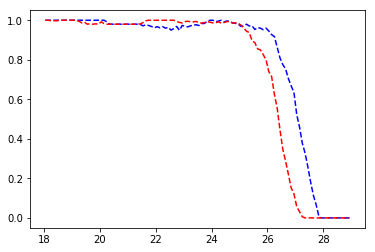

In [34]:
from scipy.interpolate import interp1d

plt.plot(h5[1][:-1]+.05, frac_f555w, 'b--')
plt.plot(h8[1][:-1]+.05, frac_f814w, 'r--')

print(h5[1][:-1][np.argmin(abs(frac_f555w - .9))] + .05)
print(h8[1][:-1][np.argmin(abs(frac_f814w - .9))] + .05)

In [35]:
# Save recovery fractions and associated magnitudes in two numpy arrays
frac_array = np.array([frac_f555w, frac_f814w])
bin_array = np.array([h5[1], h8[1]])
np.save('06my_frac.npy', frac_array)
np.save('06my_bins.npy', bin_array)